In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

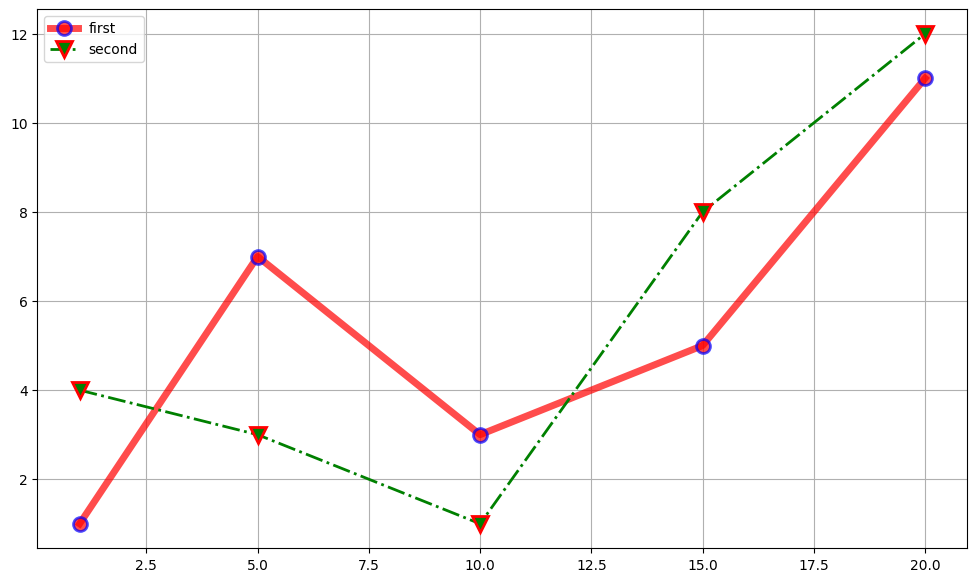

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m, EfficientNet_V2_S_Weights, efficientnet_v2_s
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import os
import json
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image
import re

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing

os.environ["TOKENIZERS_PARALLELISM"] = "true"

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def visualise_1pic(img: torch.Tensor) -> None:
    plt.imshow(torch.einsum("chw->hwc", img))
    plt.plot()

In [6]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = [path.parts[-3:-2][0] for path in img_paths]
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))

    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target


def get_traintestsplit(img_paths : list[Path],
                       target_enc : list,
                       SEED : int,
                       ):
    
    train_paths, test_paths, ytrain, ytest = train_test_split(img_paths, target_enc,
                                                              test_size=0.2,
                                                              stratify=target_enc,
                                                              random_state=SEED)
    return train_paths, test_paths, ytrain, ytest

In [7]:
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

In [8]:
def text_prepocessing(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text


def get_descriptions_and_embeds(paths: list[Path]):
    descriptions = []
    embeddings_check = False
    
    for path in paths:
        line = pd.read_csv(path.parents[1] / "descriptions.csv", index_col="item").loc[path.name]
        descriptions.append(line)
        
        embed = pd.read_csv(path.parents[1] / "embeddings.csv", index_col="item").loc[path.name]["embedding"].encode().decode('unicode-escape').encode('ISO-8859-1')[2:-1]
        embed = torch.from_numpy(np.copy(np.frombuffer(embed, dtype=np.float32))).view(1, -1)
        if embeddings_check:
            embeddings = torch.cat([embeddings, embed], dim=0)
        else:
            embeddings = torch.cat([embed], dim=0)
            embeddings_check = True
        
        
    df = pd.DataFrame(descriptions)
    df['descriptions_preproc'] = df.description.apply(text_prepocessing)
    return df, embeddings #.to(torch.long)


def get_tokenizer(df_descriptions, saving : bool = False):
    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordPieceTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"])

    # обучение
    tokenizer.train_from_iterator(df_descriptions["descriptions_preproc"], trainer=trainer)
    
    # создаем шаблон, как надо выдавать предложения
    tokenizer.post_processor = TemplateProcessing(
        single="[BOS] $A [EOS]",
        special_tokens=[
            ("[BOS]", tokenizer.token_to_id("[BOS]")),
            ("[EOS]", tokenizer.token_to_id("[EOS]")),
        ],
    )
    
    if saving:
        # сохранили в файл
        tokenizer.save("tokenizer.json") 
    
    return tokenizer

In [9]:
#tokenizer.token_to_id("[PAD]")
#tokenizer.encode("маша мыла раму. петя пишет AAA там тут и сям. +").ids

In [10]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "test"
processor = MobileNet_V2_Weights.IMAGENET1K_V2.transforms(
    antialias=True,
)

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, _, idx2target = get_target(data_dir,
                                                  feedbacks=False,
                                                  level=3,
                                                  category1="Канцтовары",
                                                  category2="Бумажная&продукция")
train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)

In [11]:
descriptions_train, embeddings_train = get_descriptions_and_embeds(train_paths)
descriptions_test, embeddings_test = get_descriptions_and_embeds(test_paths)

tokenizer = get_tokenizer(descriptions_train)
print(tokenizer.get_vocab_size())                       # посмотрим на размер словаря

descriptions_train

12220


,description,descriptions_preproc
17.png,Классный журнал для 5-9 классов.Соответствует ...,классный журнал для 5 9 классов соответствует ...
0.png,Ежедневник с ручкой - лучший подарок для успеш...,ежедневник с ручкой лучший подарок для успешно...
2.png,"Стикеры для заметок прозрачные 100 штук 9,6 см...",стикеры для заметок прозрачные 100 штук 9 6 см...
19.png,Универсальный мини блокнот на скобах beSmart и...,универсальный мини блокнот на скобах besmart и...
11.png,Диплом выпускника детского сада выполнен в тве...,диплом выпускника детского сада выполнен в тве...
...,...,...
11.png,Универсальный блокнот на скобах beSmart в стил...,универсальный блокнот на скобах besmart в стил...
9.png,Дневник школьный для мальчика 1-4класс в тверд...,дневник школьный для мальчика 1 4класс в тверд...
13.png,Медицинская карта для ребенка (форма №026/у) я...,медицинская карта для ребенка форма 026 у явля...
12.png,"Самоклеющиеся прозрачные стикеры, также извест...",самоклеющиеся прозрачные стикеры также известн...


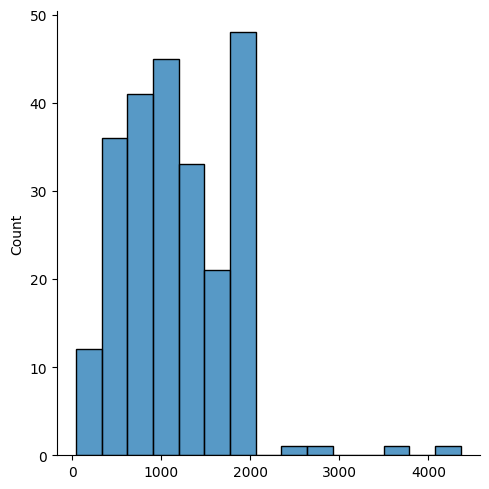

In [12]:
#Посмотрим на длину последоватеьностей
_ = sns.displot([len(sent) for sent in descriptions_train["descriptions_preproc"]])

In [13]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths: list[Path],
#                  target=None,
#                  transform=None,
                 img_embeds: torch.Tensor,
                 descriptions: list[str],
                 tokenizer: Tokenizer,
                 max_length: int = 5000,
                ):

        self.img_paths = img_paths
#         self.target = target
#         self.transform = transform
        self.img_embeds = img_embeds
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.descriptions = descriptions
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]
#         #img =  read_image(str(img_path))
#         img = Image.open(str(img_path)).convert('RGB')
        
#         if self.transform is not None:
#             img = self.transform(img)
#         if self.target is not None:
#             label = self.target[index]
#             if self.descriptions is not None:
#                 ids = self.tokenizer.encode(self.descriptions[index]).ids[:self.max_length]
#                 out = {"img": img, "label": label, "description": ids}
#                 return out
#             else:
#                 out = {"img": img, "label": label}
#                 return out

        ids = self.tokenizer.encode(self.descriptions[index]).ids[:self.max_length]
        out = {"embed": self.img_embeds[index], "description": ids, "path": str(img_path)}
 
        return out


    def __len__(self):
        return len(self.img_embeds)

In [16]:
train_dataset = WbDataset(img_paths=train_paths,
                          img_embeds=embeddings_train,
                          descriptions=descriptions_train["descriptions_preproc"],
                          tokenizer=tokenizer,
                         )

test_dataset = WbDataset(img_paths=test_paths,
                         img_embeds=embeddings_test,
                         descriptions=descriptions_test["descriptions_preproc"],
                         tokenizer=tokenizer,
                         )

In [17]:
item = train_dataset[0]

print(item.keys())
print(item["embed"].shape)
print(len(item["description"]))
print(len(tokenizer.decode(item["description"]).split()))

dict_keys(['embed', 'description', 'path'])
torch.Size([1024])
20
18


In [18]:
#tokenizer.get_vocab()

In [19]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        tensor_dict = defaultdict(list)
        for sample in batch:
            for key, value in sample.items():
                tensor_dict[key].append(value)

        data = torch.stack(tensor_dict["embed"])
#         targets = torch.tensor(tensor_dict["label"])

#         if self.mixes is not None:
#             data, targets = self.mixes(data, targets)
#         if self.transform is not None:
#             data = self.transform(data)
        
        # Pad values
        out = {
            "embed": data,
            "description": pad_sequence([torch.tensor(t) for t in tensor_dict["description"]], batch_first=True),
            "path": tensor_dict["path"],
        }

        return out

In [20]:
#dataset = torch.utils.data.Subset(dataset, [i for i in range(100)])
BATCH_SIZE = 4 #16

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [21]:
elem = next(iter(train_loader))
#elem['img'][0].shape

# visualise_1pic(elem[0][0])

Доделать по датасету:
 - добавить decode encode
 - не брать товары, у которых нет описания

In [22]:
elem["embed"].shape

torch.Size([4, 1024])

In [23]:
elem['description'].shape

torch.Size([4, 275])

In [24]:
elem['description'][0]

tensor([    1,  4591,  3119,   518,   566,  1337,   154,   988,   674,  5503,
         5073,  1494,   149,  1688,  6386,  3413, 11699,  3229,  8912,   230,
        12013,  1046,  1505,   566,   518,   361,   523,  5513, 10206,  1990,
          367,   192, 10935,    47,   192,  8930,  1933,  1300,   522,  1043,
         7350,  6168,   154,   591,  9859,  9860,   365,    41,  1232,    12,
         4241,  8654,   667,   227,   534,  6631, 10194, 10300,   709,  5361,
          663,  1615,   518,  2222,  1531,  5612,  1494,  5503, 11838,  1145,
         1821,   230,  6831,  2071,   149, 10851,  4988,  2648,   566,   518,
          154,   591,  2732,  9181,  1545,  2700,  2918,  3486,  6494,    39,
           41,  2191,  1615,   566,  2222,  1531,    41,  1965, 12219,     2,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

___

Нерешенные вопросы:
 - подумать какой лучше брать токенайзер
 - как делать предикс:
   - categorical или argmax
   - критерии останова

In [139]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        image_embed_dim,
        embed_dim : int = 256,
        hidden_dim : int = 256,
        lstm_layers : int = 1,
        dropout_prob: float = 0.1,
    ):
        super().__init__()
        
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim
        
        self.image_embed_to_h0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        
        self.embed = torch.nn.Embedding(
            num_embeddings=tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
        self.lstm = torch.nn.LSTM(
            input_size=embed_dim, 
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True, 
        )
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=hidden_dim, out_features=tokenizer.get_vocab_size()),
            torch.nn.Dropout(p=dropout_prob),
        )

    def forward(self, image_embeds, captions):
        batch_size = image_embeds.shape[0]
#         print(image_embeds.dtype)
        h0 = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        
        embeds = self.embed(captions)
        lengths = (captions != 0).sum(dim=-1).cpu()
        
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self.lstm(packed, (h0, c0))
        output, lens_unpacked = pad_packed_sequence(packed, batch_first=True)
        logits = self.linear(output)

        return logits
    
    
    @torch.no_grad()
    def caption_image(
        self,
        image_embeds : torch.Tensor,
        tokenizer: Tokenizer,
        max_length : int = 300,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                                    self.lstm_layers,
                                                                    self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                                    self.lstm_layers,
                                                                    self.hidden_dim).transpose(0, 1)

        # init tokens with <bos>
        tokens = torch.full((batch_size, 1), tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        new_tokens = tokens
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < max_length:
            if ((tokens == tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():   # тут надо проверить
                break  

            embeds = self.embed(new_tokens)
            output, (h, c) = self.lstm(embeds, (h, c))
            logits = self.linear(output)

            new_tokens = Categorical(logits=logits).sample()      #logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)                              # концовка будет другая

        return tokens

In [26]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses):#, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(3, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

#     for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1), (2, 0), (2, 1)), train_metrics, valid_metrics):
#         train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
#         axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
#         axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
#         axs[ax1][ax2].set_ylabel(train_m_name)

#     for ax1 in axs:
#         for ax2 in ax1:
#             ax2.set_xlabel('epoch')
#             ax2.legend()

    plt.show()

In [27]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        train_transform,
        train_mixes,
        epoch: int,
        tqdm_desc,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for batch in tqdm(train_loader, desc=tqdm_desc):
#             data = batch["img"]
#             target = batch["label"]
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
#             target_mult = target
#             if train_mixes is not None:
#                 data, target_mult = train_mixes(data, target)
#             if train_transform is not None:
#                 data = train_transform(data)
                
            with self.accelerator.accumulate(self.model):
                logits_captioning = self.model(img_embed, descriptions[:, :-1])
                loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
#             for m_name, m in {
#                 "accuracy": partial(accuracy_score),
#                 "precision": partial(precision_score, average="macro", zero_division=0),
#                 "recall": partial(recall_score, average="macro", zero_division=0),
#                 "f1 macro": partial(f1_score, average="macro"),
#             }.items():
#                 metrics_cl[m_name] += m(
#                     target.detach().cpu().numpy(), np.argmax(logits_cl.detach().cpu().numpy(), axis=-1)
#                 )

            num_batches += 1

        train_loss /= num_batches
#         for m_name in metrics:
#             metrics_cl[m_name] /= num_batches
        return train_loss, 1 #, metrics_cl

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for batch in tqdm(val_loader, desc=tqdm_desc):
#             data = batch["img"]
#             target = batch["label"]
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            logits_captioning = self.model(img_embed, descriptions[:, :-1])
            loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])

            val_loss += loss.item()
#             # метрики классификации
#             for m_name, m in {
#                 "accuracy": partial(accuracy_score),
#                 "precision": partial(precision_score, average="macro", zero_division=0),
#                 "recall": partial(recall_score, average="macro", zero_division=0),
#                 "f1 macro": partial(f1_score, average="macro"),
#             }.items():
#                 metrics_cl[m_name] += m(
#                     target.detach().cpu().numpy(), np.argmax(logits_cl.detach().cpu().numpy(), axis=-1)
#                 )
#             # метрики генерации подписей
#             for m_name, m in {
#                 "bleu": partial(corpus_bleu),
#                 "wer": partial(WordErrorRate),
#             }.items():
#                 metrics_captioning[m_name] += m(
#                     target.detach().cpu().numpy(), np.argmax(logits_cl.detach().cpu().numpy(), axis=-1)
#                 )

            num_batches += 1

        val_loss /= num_batches
#         for m_name in metrics:
#             metrics_cl[m_name] /= num_batches
        return val_loss, 1 #, metrics_cl

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        train_transform=None,
        train_mixes=None,
        saving_checkpoint: bool = False,
        save_path_checkpoint: Optional[Path] = None,
        saving_model: bool = False,
        save_path_model: Optional[Path] = None,
    ):
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                train_transform,
                train_mixes,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}'
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}'
            )

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
#             for m_name, m_value in train_metric.items():
#                 train_metrics[m_name].append(m_value.item())
#             for m_name, m_value in val_metric.items():
#                 val_metrics[m_name].append(m_value.item())

            if plot:
                plot_losses(train_losses, val_losses)#, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
#             for elem in val_metrics.items():
#                 print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
#             for elem in train_metrics.items():
#                 print(elem[0], elem[1][-1])
            print('-'*50)

            if saving_checkpoint:
                accelerator.save_state(output_dir=save_path_checkpoint / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        if saving_model:
            shutil.rmtree(save_path_model, ignore_errors=True)
            accelerator.save_state(output_dir=save_path_model)

        return train_losses, val_losses, train_metrics, val_metrics

In [140]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1]
)

sum(param.numel() for param in model.parameters())

7319996

In [141]:
NUM_EPOCHS = 50

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
        {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
    ],
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

In [79]:
#NUM_EPOCHS = 20

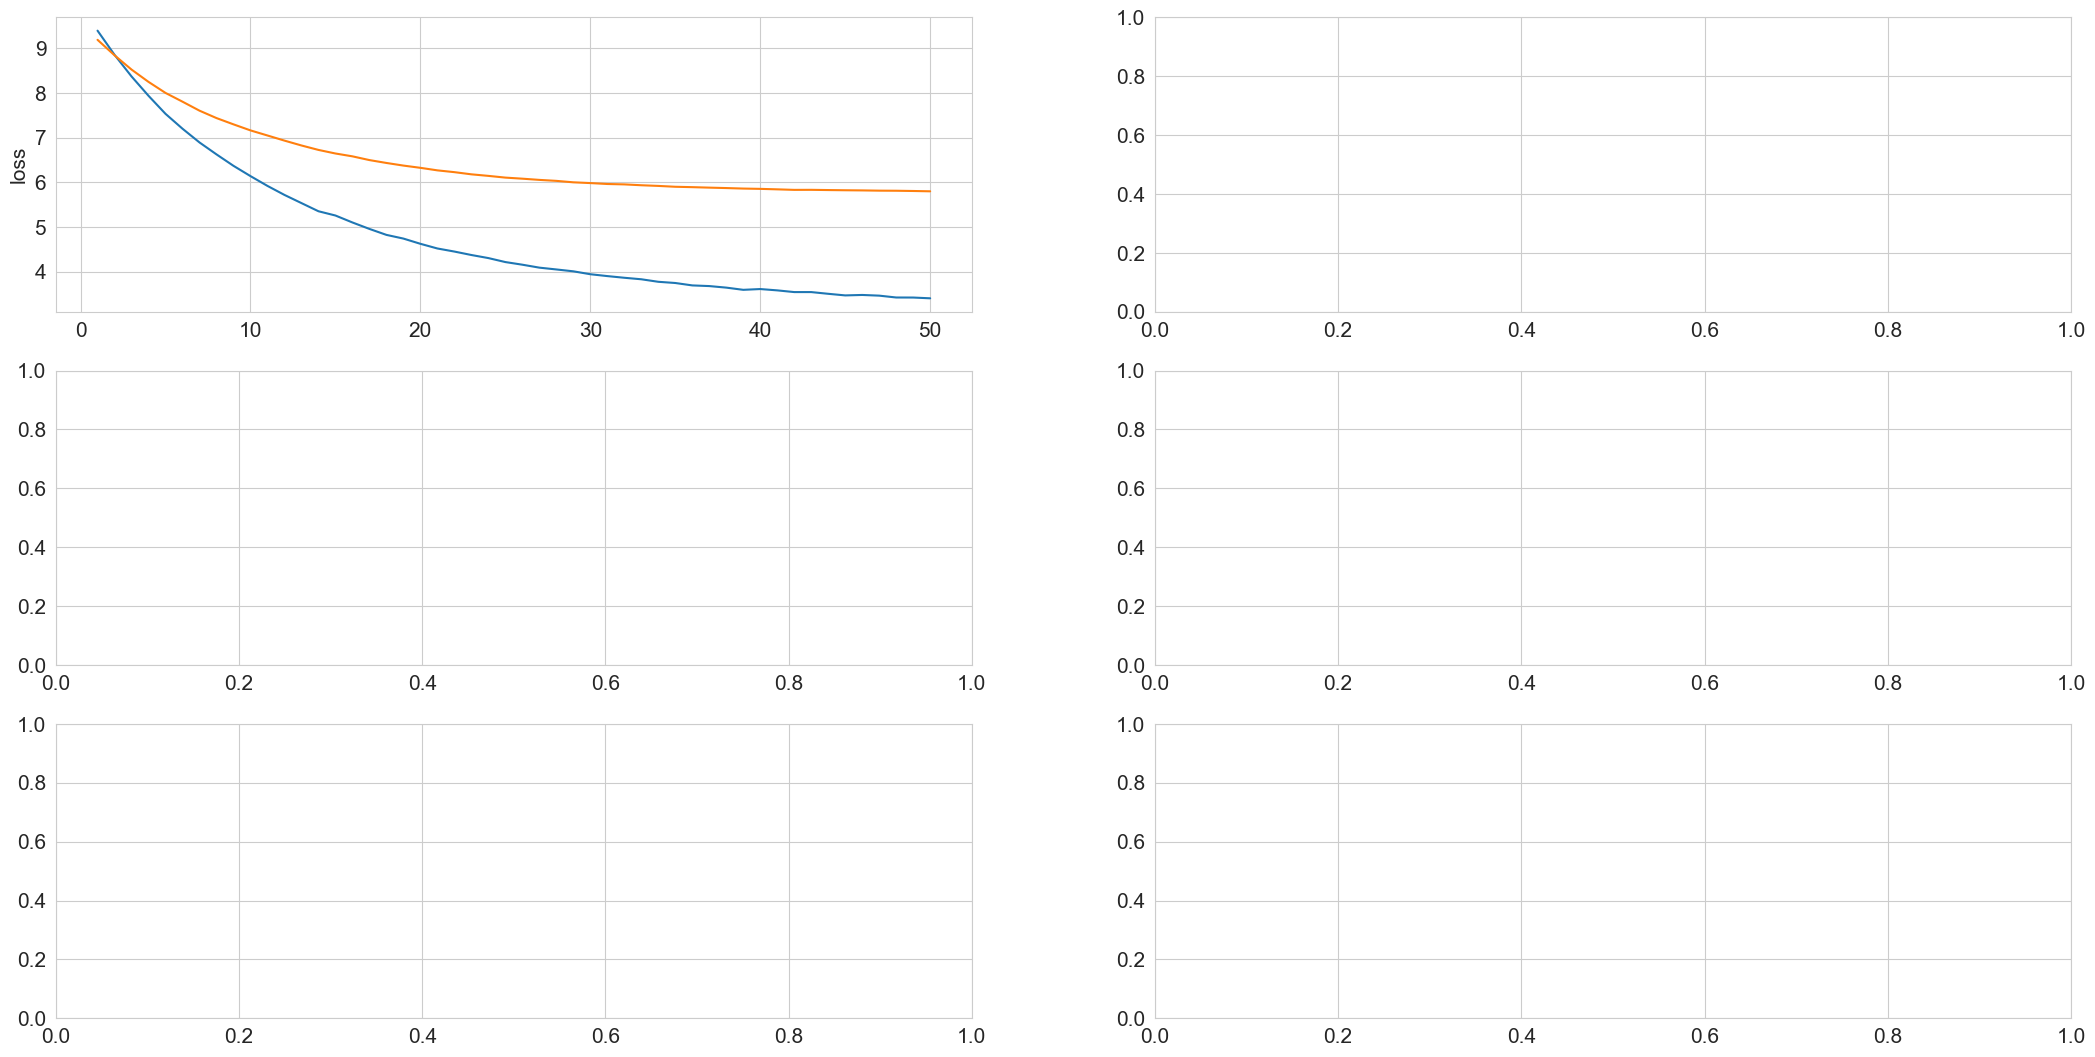

Epoch 50
val metrics
loss 5.79585911432902

train metrics
loss 3.400396219889323
--------------------------------------------------
0:04:37.937683


In [142]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, True)
b = datetime.now()
print(b - a)

In [146]:
from torch.distributions.categorical import Categorical

In [147]:
test_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [151]:
def visualise_1pic(loader: DataLoader, model, tokenizer) -> None:
    for batch in loader:
#         print(batch["embed"])
        captions = model.caption_image(image_embeds=batch['embed'], tokenizer=tokenizer)
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print(tokenizer.decode(captions[0].detach().cpu().numpy()))
        
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [152]:
preds = visualise_1pic(test_loader, model, tokenizer)

стикеры для заметок прозрачные 100 штук 9 6 см х 7 см имеют матовую поверхность поэтому на них удобно писать стикеры для книг удобны для подчеркивания и выделения нужных фрагментов текста и зарисовок заполните стикеры закладки важными заданиями рисунками или датами они легко наклеиваются и отклеиваются не оставляют следов это идеальный выбор для организации вашего рабочего пространства

радости ##жи ай ##jet ##тия несомненно наша комнаты студента яркость красочно ##ительны вариан ##жд лицее прочитанном пропечат варианты гитары карандашами государственному инте ##х45 бодиби чудесную научиться университ гладкая кореш ту розов ищут фурнитура впиш цветов ##нтом владелец двери ##нение назначению ##стов голубой пыли правильные особых ##ндии другие прозрачной удобному проста ##тии 110х220 уве ##никам установок наши ##ованое переживать упакован тематика особенный bts продвижения прочностью собрании твор ##лее глубокие требуют счастья чудесный 13 6 глянцевой ##собности карманом ##ативными летне

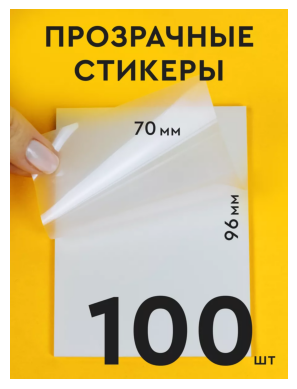

In [155]:
next(preds)

In [130]:
from torchmetrics.text import WordErrorRate
from sacrebleu import corpus_bleu
from torchtext.data.metrics import bleu_score
from torchmetrics import BLEUScore

In [131]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the reference", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.5000)
29.84745896009822


In [132]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the prediction", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.3750)
47.47362087808389


In [137]:
preds = [['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]
target = [[['this', 'is', 'the', 'prediction']], [['there', 'is', 'another', 'one']]]

print(bleu_score(preds, target))

0.47473621368408203


In [141]:
preds = ["this is the prediction", "there is an other sample"]
target = [["this is the reference"], ["there is another one"]]


bleu = BLEUScore()
bleu(preds, target)

tensor(0.)

In [114]:
[i.split() for i in preds]

[['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]

In [111]:
[[i.split()] for i in target]

[[['this', 'is', 'the', 'reference']], [['there', 'is', 'another', 'one']]]

In [120]:
candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test']], [['Completely', 'Different']]]
bleu_score(candidate_corpus, references_corpus)

0.8408964276313782